In [321]:
import numpy as np
import pandas as pd

import datetime

import sys
sys.path += ['..']
from data_collection.data_collection import Logger
import plotly.express as px
import scipy.signal as ss

import torchaudio as ta
import torch as tch
tafn = ta.functional
tatx = ta.transforms
from pathlib import Path

from IPython.display import Audio
from nb_tools import *
from scipy.fft import fft, ifft, fftfreq
from functools import partial
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
rate = 16000

# 1. Noise mixing

In [ ]:
def show_spectrum(sig, rate=rate, **kwargs):
    f, t, sxx = ss.spectrogram(sig, fs=rate)
    return px.imshow(np.log10(sxx), y=f, x=t, aspect='auto' )
#show_spectrum(data['ee_plus_runnng_c0'][0], nperseg=4096)

In [ ]:
def mix(s1, s2, w1, w2):
    l1 = s1.shape[-1]
    l2 = s2.shape[-1]
    assert l1 >= l2

    pad_len = l1 - l2

    s1_idx = 0
    segments = []

    while s1_idx < l1:
        end_idx = min(l1, s1_idx+l2)

        s2_to_add = s2[:, :end_idx-s1_idx] # TODO: flip the noise every other iteration

        com_seg = s1[:, s1_idx:end_idx]*w1 + s2_to_add*w2
        segments.append(com_seg)
        s1_idx = end_idx
    return np.concatenate(segments, axis=-1)
    

In [ ]:
from nb_tools import show_global_variables
@np.vectorize
def tri(idx, length):
    end = length - 1
    if not (idx // end) % 2: 
        return idx % end
    else: 
        return end - (idx % end)

@show_global_variables
def loop(sig, fs, dur, seg_st, seg_ed):
    hop_length = 200
    win_dur = hop_length/fs

    seg_st = seg_st//win_dur
    seg_ed = seg_ed//win_dur



    spectra = tatx.Spectrogram(power=2, hop_length=hop_length)(sig)

    n_win = dur//win_dur
    idx = tri(np.arange(n_win), seg_ed-seg_st) + seg_st



    return tatx.GriffinLim(hop_length=hop_length)(spectra[..., idx])
#sigl = loop(ee0_0*1e14, 16000, 20, 4, 8)

In [ ]:
@show_global_variables
def freq_phase(n, fs, freq):
    return np.linspace(0, n/fs*freq*np.pi*2, n, endpoint=False)%(2*np.pi)

@show_global_variables
def fixedtime(fs, te):
    n_sample = int(te*fs)
    dt = [1/fs]*n_sample
    return np.cumsum(dt)

@show_global_variables
def jitteredtime(fs, te):
    n_sample = int(te*fs)
    ddt = (np.random.random(n_sample)-0.5)*(1/(fs*25))
    dt = np.cumsum(ddt) + 1/fs
    return np.cumsum(dt)

@show_global_variables
def varyingtime(fs, te):
    n_sample = int(te*fs)
    dddt = (np.random.random(n_sample)-0.5)*(1/(fs*20000000))
    ddt = np.cumsum(dddt)
    dt = np.cumsum(ddt) + 1/fs
    return np.cumsum(dt)

@show_global_variables
def time2phase(t, f):
    return (t*np.pi*2*f )% (2*np.pi)
    
@show_global_variables
def harmonics(times, basefreq, n_har=30):
    sigs = np.zeros((n_har, len(times)))
    for n in range(1, n_har+1):
        sigs[n-1] = np.sin(time2phase(times, basefreq*n)) 

    return sigs

@show_global_variables
def find_nearest(x, findfrom):
    return np.argmin(np.abs(x[:, None] - findfrom[None, :]), axis=1)

@show_global_variables
def butterworth_highpass(sig, fs, lf):
    filter = ss.butter(8, lf, fs=fs, btype='high', output='sos')
    return ss.sosfiltfilt(filter, sig)

@show_global_variables    
def butterworth_lowpass(sig, fs, lf):
    filter = ss.butter(8, lf, fs=fs, btype='low', output='sos')
    return ss.sosfiltfilt(filter, sig)

@show_global_variables    
def butterworth_filter(sig, fs, freq, btype, order=8):
    filter = ss.butter(order, freq, fs=fs, btype=btype, output='sos')
    return ss.sosfiltfilt(filter, sig)

@show_global_variables
def get_avg_freq_from_sigs_spectro(sigs, rate=rate):

    def get_avg_freq(sig, rate=rate):
        f, _, sxx = ss.spectrogram(sig, fs=rate,)
        return f, (sxx**(1/2)).mean(-1)

    result = []
    for sig in sigs:
        f, meaned = get_avg_freq(sig, rate)
        result.append(meaned)

    return f, np.stack(result, axis=-1).mean(-1)


@show_global_variables
def fftfilter(sig,fs, mags, magfreqs):
    x = fft(sig)
    freqs = fftfreq(sig.shape[-1], 1/fs)
    fidx = find_nearest(freqs, magfreqs)

    x *= mags[fidx]
    
    return ifft(x)

@show_global_variables
def get_mag_of_freq_smooth(siglist, fs=16000, smooth_window=8000):
    fullsig = np.concatenate(siglist, axis=-1)
    mags = np.abs(fft(fullsig))[0]

    as_strided = np.lib.stride_tricks.as_strided
    stride_size = mags.strides[0]
    mags/=mags.max()
    mags_re = as_strided(
        mags, 
        shape=(len(mags), smooth_window),
        strides=(stride_size, stride_size)
    ).mean(-1)[::smooth_window//2]

    freqs = fftfreq(len(mags), 1/fs)[::smooth_window//2]

    return freqs, mags_re


In [ ]:
@show_global_variables
def load_wav(path):
    path = Path(path)

    data = {}
    for f in filter(lambda f:f.suffix=='.wav', path.iterdir()):
        sig, fs = ta.load(f)
        data[f.stem] = sig

    return data

rate=16000
Audio = partial(Audio, rate=16000)

data = load_wav('../../log/audio_data')

In [ ]:
def sec(s, rate=rate):
    return int(s*rate)

In [ ]:
noise = data['running_noise_c0'][:, rate*25:-rate*14]
ee0_0 = data['ee0deg_floor_c0'][:, rate*5:-rate*5]
ee0_1 = data['ee0deg_floor_c1'][:, rate*5:-rate*5]

ee90_0 = data['ee_90deg_floor_c0'][:, sec(2.3):sec(16)]
ee90_1 = data['ee_90deg_floor_c1'][:, sec(2.3):sec(16)]

ee180_0 = data['ee_180deg_floor_c0'][:, sec(0):sec(21)]
ee180_1 = data['ee_180deg_floor_c1'][:, sec(0):sec(21)]


In [752]:
def detect(sig, fs=16000, frame_time=0.5, win_length=3, freq_high=500):
    if not isinstance(sig, tch.Tensor):
        sig = tch.tensor(sig.copy())
    return tafn.detect_pitch_frequency(
        sig, 
        fs,
        frame_time=frame_time, win_length=win_length, freq_high=freq_high
    
    )
def notch(sig, fs=16000, freq=(700, 1800),):
    return butterworth_filter(sig, fs=fs, freq=freq, btype='bandstop')

In [ ]:
4096/16000

In [ ]:
from scipy.fft import rfft, rfftfreq, irfft

In [373]:

def rolling_mean(arr, kernel=np.ones(3)/3): 
    return np.correlate(arr, kernel, mode='same')

def mirror_pad(arr, length):
    return np.concatenate([arr[..., length:0:-1], arr, arr[arr.shape[-1]-2:-length-2:-1]], axis=-1)

def rolling_mean2(arr, window):
    
    return np.correlate(mirror_pad(arr, window), np.ones(window)/window, mode='same')[..., window:-window]

def adjust(sxx, bandwidth=45):
    return sxx - rolling_mean(sxx, np.ones(bandwidth)/bandwidth) 
    

def detect2a(sig, fs=16000, freq_range=(100, 500)):
    sxx = np.log(np.square(np.abs(rfft(sig))))
    sxxsxx = np.square(np.abs(rfft(adjust(sxx, bandwidth=5))))

    freqs = rfftfreq(sig.shape[-1], 1/fs)
    freqs = 1/rfftfreq(len(freqs), freqs[1]-freqs[0])
    idx = bidx(freqs, freq_range)
    idx = bidx(freqs, freq_range)
    argmax = np.argmax(sxxsxx[idx], axis=-1)
    return freqs[idx][argmax]
    


In [375]:
rolling_mean2(np.array([1,2,3,4,5]), 2)

array([1.5, 1.5, 2.5, 3.5, 4.5])

In [136]:
def bidx(a, lim):
    return (a>lim[0]) & (a<lim[1])

In [137]:
def detect2b(sig, fs=16000, freq_range=(100, 500)):
    sxx = np.log(np.square(np.abs(rfft(sig))))
    sxxsxx = np.square(np.abs(rfft(sxx)))

    freqs = rfftfreq(sig.shape[-1], 1/fs)
    freqs = 1/rfftfreq(len(freqs), freqs[1]-freqs[0])
    idx = bidx(freqs, freq_range)
    argmax = np.argmax(sxxsxx[idx], axis=-1)
    return freqs[idx][argmax]
    

In [ ]:
def detect3(sig, fs=16000):
    sxx = np.log(np.square(np.abs(rfft(sig))))
    sxxsxx = np.square(np.abs(rfft(sxx)))
    
    return irfft(sxxsxx)

In [234]:
find_nearest

<function __main__.find_nearest(x, findfrom)>

In [ ]:
def windowing(sig, win_size, step_size=1):
    assert len(sig.shape) ==1 
    stride = sig.strides[0]
    length = sig.shape[0]
    return np.lib.stride_tricks.as_strided(
        sig, 
        shape=((length-win_size)//step_size, win_size), 
        strides=(stride*step_size, stride)
    )

In [509]:
s = ee0_0[0]
se = mix(ee0_0, noise, 1, .2)[0]

In [ ]:
window(s.numpy(), 256).apply_along_axes(detect2, axis=1)

In [141]:

def detect2_temp(arr, window, step_size):
    a = windowing(arr, window, step_size=step_size)
    d = np.apply_along_axis(detect2a, axis=-1, arr=a)
    return d


In [800]:
#d = detect2c(s.numpy(), 4096, 512)
def temp(s):
    if not isinstance(s, np.ndarray):
        s = s.numpy()
    return detect2_temp(s, 4096, 512)

def temp(s):
    return detect(s, 16000, 0.5)


In [801]:
#freqs, mags = get_avg_freq_from_sigs_spectro([ee0_0, ee0_1, ee90_0, ee90_1, ee180_0, ee180_1])   

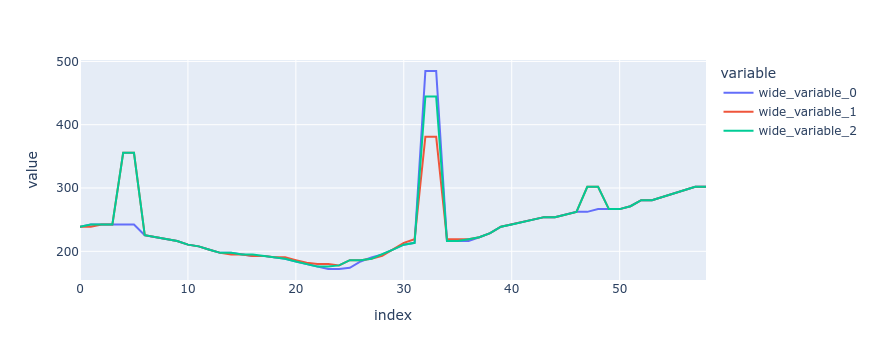

In [802]:
s = ee0_0[0]
se = mix(ee0_0, noise, 1, .2)[0]
px.line(y=[temp(notch(s[:-16000*4])), temp(se[:-16000*4]), temp(notch(se[:-16000*4]))])

In [207]:
import torch
import math
from typing import *
from torch import Tensor
@show_global_variables
def _compute_nccf(waveform:Tensor, sample_rate: int, frame_time: float, freq_low: int)->Tensor:
    r"""
    Compute Normalized Cross-Correlation Function (NCCF).

    .. math::
        \phi_i(m) = \frac{\sum_{n=b_i}^{b_i + N-1} w(n) w(m+n)}{\sqrt{E(b_i) E(m+b_i)}},

    where
    :math:`\phi_i(m)` is the NCCF at frame :math:`i` with lag :math:`m`,
    :math:`w` is the waveform,
    :math:`N` is the length of a frame,
    :math:`b_i` is the beginning of frame :math:`i`,
    :math:`E(j)` is the energy :math:`\sum_{n=j}^{j+N-1} w^2(n)`.
    """

    EPSILON = 10 ** (-9)

    # Number of lags to check
    lags = int(math.ceil(sample_rate / freq_low))

    frame_size = int(math.ceil(sample_rate * frame_time))

    waveform_length = waveform.size()[-1]
    num_of_frames = int(math.ceil(waveform_length / frame_size))

    p = lags + num_of_frames * frame_size - waveform_length
    waveform = torch.nn.functional.pad(waveform, (0, p))

    # Compute lags
    output_lag = []
    for lag in range(1, lags + 1):
        s1 = waveform[..., :-lag].unfold(-1, frame_size, frame_size)[..., :num_of_frames, :]
        s2 = waveform[..., lag:].unfold(-1, frame_size, frame_size)[..., :num_of_frames, :]

        output_frames = (
            (s1 * s2).sum(-1)
            / (EPSILON + torch.linalg.vector_norm(s1, ord=2, dim=-1)).pow(2)
            / (EPSILON + torch.linalg.vector_norm(s2, ord=2, dim=-1)).pow(2)
        )

        output_lag.append(output_frames.unsqueeze(-1))

    nccf = torch.cat(output_lag, -1)

    return nccf

def _combine_max(a: Tuple[Tensor, Tensor], b: Tuple[Tensor, Tensor], thresh: float = 0.99) -> Tuple[Tensor, Tensor]:
    """
    Take value from first if bigger than a multiplicative factor of the second, elementwise.
    """
    mask = a[0] > thresh * b[0]
    values = mask * a[0] + ~mask * b[0]
    indices = mask * a[1] + ~mask * b[1]
    return values, indices


def _find_max_per_frame(nccf: Tensor, sample_rate: int, freq_high: int) -> Tensor:
    r"""
    For each frame, take the highest value of NCCF,
    apply centered median smoothing, and convert to frequency.

    Note: If the max among all the lags is very close
    to the first half of lags, then the latter is taken.
    """

    lag_min = int(math.ceil(sample_rate / freq_high))

    # Find near enough max that is smallest

    best = torch.max(nccf[..., lag_min:], -1)

    half_size = nccf.shape[-1] // 2
    half = torch.max(nccf[..., lag_min:half_size], -1)

    best = _combine_max(half, best)
    indices = best[1]

    # Add back minimal lag
    indices += lag_min
    # Add 1 empirical calibration offset
    indices += 1

    return indices
    
def detect_pitch_frequency(
    waveform: Tensor,
    sample_rate: int,
    frame_time: float = 10 ** (-2),
    win_length: int = 30,
    freq_low: int = 85,
    freq_high: int = 3400,
) -> Tensor:
    r"""Detect pitch frequency.

    .. devices:: CPU CUDA

    .. properties:: TorchScript

    It is implemented using normalized cross-correlation function and median smoothing.

    Args:
        waveform (Tensor): Tensor of audio of dimension `(..., freq, time)`
        sample_rate (int): The sample rate of the waveform (Hz)
        frame_time (float, optional): Duration of a frame (Default: ``10 ** (-2)``).
        win_length (int, optional): The window length for median smoothing (in number of frames) (Default: ``30``).
        freq_low (int, optional): Lowest frequency that can be detected (Hz) (Default: ``85``).
        freq_high (int, optional): Highest frequency that can be detected (Hz) (Default: ``3400``).

    Returns:
        Tensor: Tensor of freq of dimension `(..., frame)`
    """
    # pack batch
    shape = list(waveform.size())
    waveform = waveform.reshape([-1] + shape[-1:])

    nccf = _compute_nccf(waveform, sample_rate, frame_time, freq_low)
    indices = _find_max_per_frame(nccf, sample_rate, freq_high)
    #indices = _median_smoothing(indices, win_length)

    # Convert indices to frequency
    EPSILON = 10 ** (-9)
    freq = sample_rate / (EPSILON + indices.to(torch.float))

    # unpack batch
    freq = freq.reshape(shape[:-1] + list(freq.shape[-1:]))

    return freq


Global variables of <function '_compute_nccf'>: 
math                                                <class 'module'>
int                                                 <class 'type'>
torch                                               <class 'module'>
range                                               <class 'type'>



In [314]:
def percence2a(sig, fs, basefreq, highest_freq):
    sxx = (np.abs(rfft(sig))**2)
    freqs = rfftfreq(sig.shape[-1], 1/fs)
    return percence_a(sxx, freqs, basefreq, highest_freq)
    
def percence2b(sig, fs, basefreq, highest_freq):
    sxx = (np.abs(rfft(sig))**2)
    freqs = rfftfreq(sig.shape[-1], 1/fs)
    return percence_b(sxx, freqs, basefreq, highest_freq)


def percence_a(sxx, freqs, basefreq, highest_freq):
    freq_to_detect = np.arange(basefreq, highest_freq, basefreq)
    idx = np.unique(find_nearest(freq_to_detect, freqs))
    return (np.log10(sxx[..., idx]).mean())
    
def percence_b(sxx, freqs, basefreq, highest_freq):
    freq_to_detect = np.arange(basefreq, highest_freq, basefreq)
    idx = np.unique(find_nearest(freq_to_detect, freqs))
    return np.log10((sxx[..., idx]).mean())
    

In [286]:
percence2(s[100:4096+100].numpy(), 16000, 242, 5000)

-32.49998

In [287]:
percence2(s[100:4096+100].numpy(), 16000, 242, 5000)

-32.49998

In [328]:
def get_sxx(x):
    return np.log10(np.abs(rfft(x)))

In [748]:
tw = s[8000*26:4096+8000*26].numpy()
#tw = s[8000*2:4096+8000*2].numpy()
#tw = se[8000*29:4096+8000*29]

sxx = get_sxx(tw)
sxx_s = rolling_mean2(get_sxx(tw), 200)
ds = rolling_mean2(sxx, 3)-sxx_s 
ps = 1-stats.norm.cdf(ds/(ds.std()))
freqs = rfftfreq(4096, 1/16000)

def get_idx(basefreq, freqs, highest_freq):
    freq_to_detect = np.arange(basefreq, highest_freq, basefreq)
    return np.unique(find_nearest(freq_to_detect, freqs))
    
@np.vectorize
def temp(f):
    ps_to_use = ps[..., get_idx(f, freqs, 8000)]
    
    #return np.prod((ps_to_use[np.argsort(ps_to_use)[:10]]))    
    return (np.log(np.prod(ps_to_use))/len(ps_to_use))


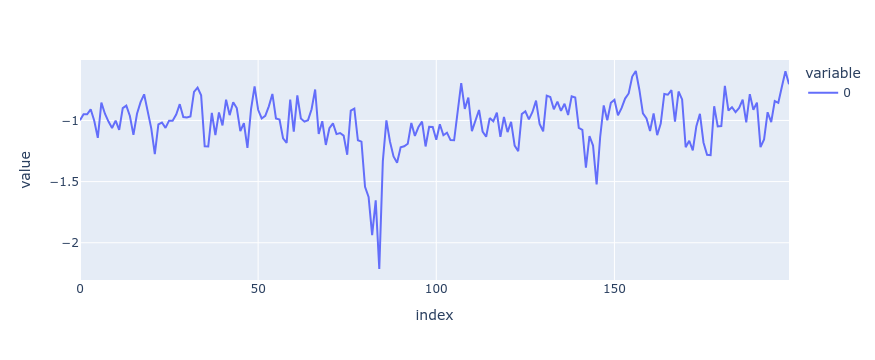

In [749]:
px.line(temp(np.arange(100, 300, 1)))

In [794]:

def get_idx(basefreq, highest_freq, freqs):
    freq_to_detect = np.arange(basefreq, highest_freq, basefreq)
    return np.unique(find_nearest(freq_to_detect, freqs))
    
@np.vectorize(excluded={2, 3, 'ps', 'freqs'})
def freq_percence_i(basefreq, highest_freq, ps, freqs):
    ps_to_use = ps[..., get_idx(basefreq, highest_freq, freqs)]
    return np.log(np.prod(ps_to_use))/len(ps_to_use)

def freq_percence(sig, fs, basefreq, highest_freq):

  
    assert len(sig.shape) == 1
    assert len(sig) == 4096 
    
    freqs = rfftfreq(len(sig), 1/fs)
    sxx = np.log10(np.abs(rfft(sig)))
    sxx_dev = rolling_mean2(sxx, 5) - rolling_mean2(sxx, 200)
    ps = 1-stats.norm.cdf(sxx_dev/(sxx_dev.std()))
    
    #return freq_percence_i(np.arange(-2, 3, 1)+basefreq, highest_freq, ps, freqs)#.mean()
    return freq_percence_i(basefreq, highest_freq, ps, freqs)#.mean()


In [795]:
pitches = detect(se, frame_time=0.25)
v = np.zeros(len(pitches))
for i, f in enumerate(pitches):
    tw = se[4000*i:4096+4000*i]#.numpy()
    v[i] = (freq_percence(tw, 16000, np.arange(-2, 3, 1)+f.numpy(), 8000)).mean()


In [796]:
f.numpy()

array(484.8485, dtype=float32)

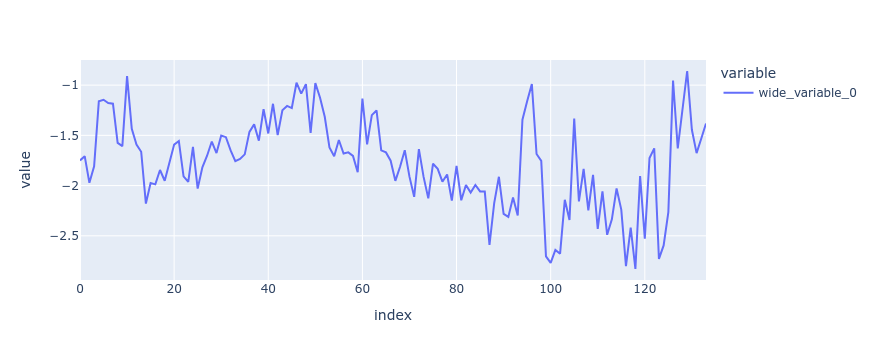

In [797]:
px.line(y=[v])

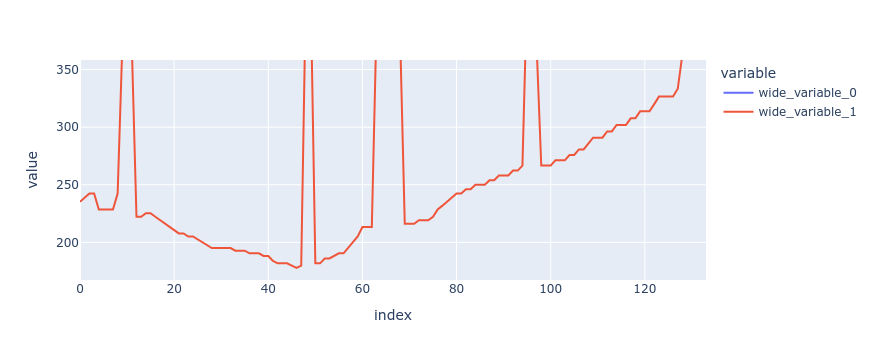

In [798]:
px.line(y=[v*500+500, pitches])

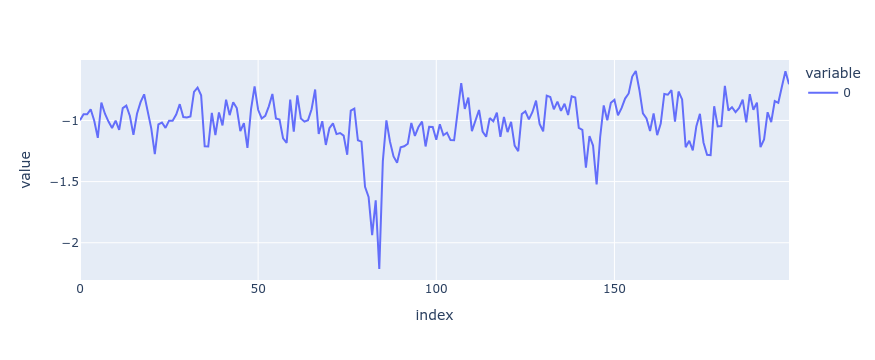

In [751]:
tw = s[8000*26:4096+8000*26].numpy()
px.line(freq_percence(tw, 16000, np.arange(100, 300, 1), 8000))

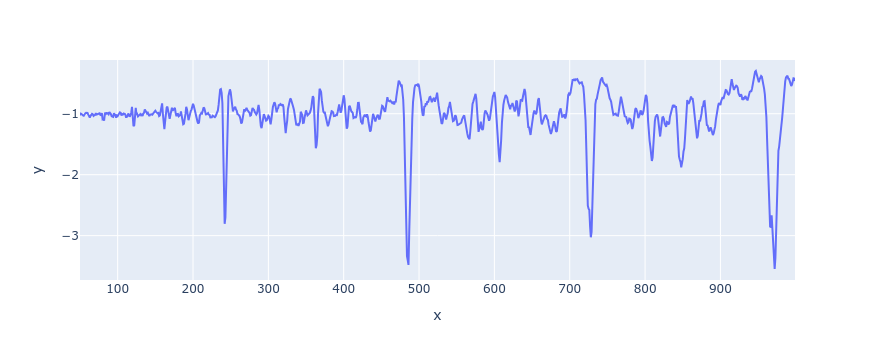

In [597]:
px.line(y=(rolling_mean2(temp(np.arange(50, 1000, 1)), 3)),x=np.arange(50, 1000, 1))

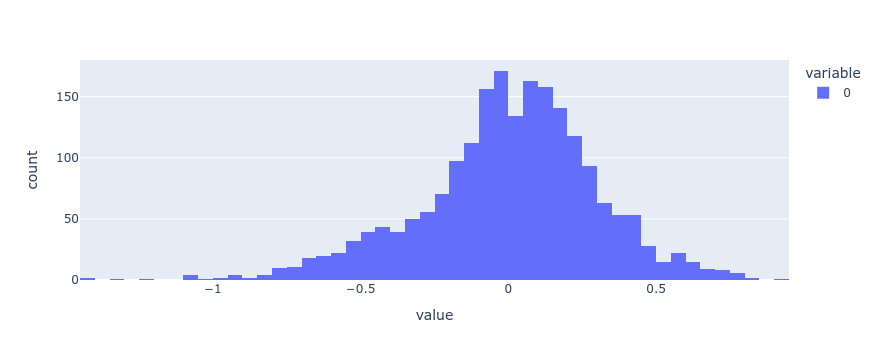

In [399]:
d = sxx_s - rolling_mean2(sxx, 4)
px.histogram(d)

In [408]:
from scipy import stats

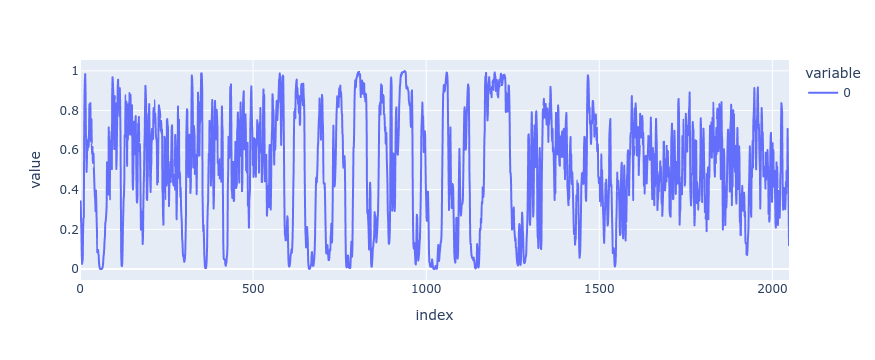

In [ ]:
np.log(np.abs(rfft(s[100:4096+100].numpy())))

In [ ]:
(fft - smooth).std 

In [335]:
rolling_mean2

<function __main__.rolling_mean2(arr, window)>

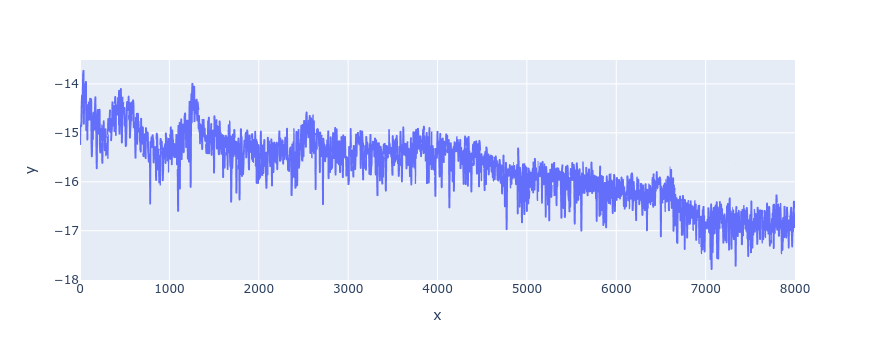

In [333]:
px.line(x=rfftfreq(4096, 1/16000), y=np.log10(np.abs(rfft(noise[0, 100:4096+100].numpy()))))

In [274]:
percence2(s[100:4096+100].numpy(), 16000, 400, 5000)

-30.462006

In [230]:
x.shape

torch.Size([68])

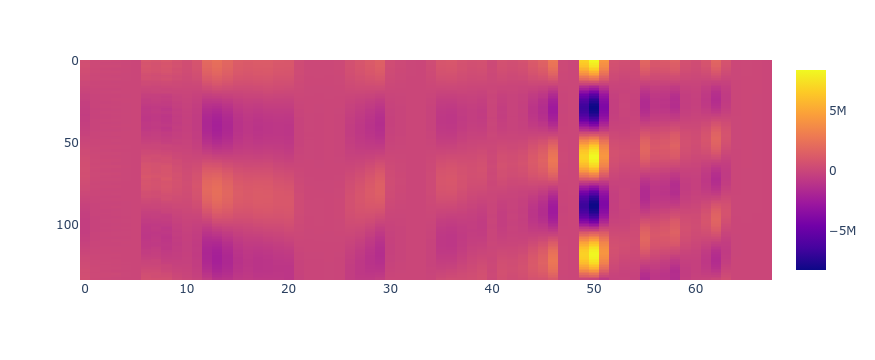

In [200]:
px.imshow(x.T, aspect='auto')

In [224]:
x

tensor([238.8060, 242.4243, 242.4243, 242.4243, 242.4243, 761.9048, 222.2222,
        225.3521, 219.1781, 216.2162, 210.5263, 207.7922, 202.5316, 197.5309,
        197.5309, 195.1219, 192.7711, 192.7711, 190.4762, 188.2353, 183.9081,
        179.7753, 175.8242, 172.0430, 170.2128, 173.9130, 183.9081, 190.4762,
        195.1219, 202.5316, 210.5263, 213.3333, 761.9048, 761.9048, 213.3333,
        216.2162, 216.2162, 222.2222, 228.5714, 238.8060, 242.4243, 246.1538,
        250.0000, 253.9683, 253.9683, 258.0645, 262.2951, 262.2951, 761.9048,
        266.6667, 266.6667, 271.1864, 280.7018, 280.7018, 285.7143, 290.9091,
        296.2963, 301.8868, 301.8868, 307.6923, 313.7255, 326.5306, 326.5306,
        340.4255, 355.5556, 761.9048, 761.9048, 761.9048])

In [232]:
tafn.detect_pitch_frequency(s, 16000, .5, 3, 120)

tensor([ 238.8060,  242.4243,  242.4243,  242.4243,  242.4243,  242.4243,
         225.3521,  222.2222,  219.1781,  216.2162,  210.5263,  207.7922,
         202.5316,  197.5309,  197.5309,  195.1219,  192.7711,  192.7711,
         190.4762,  188.2353,  188.2353, 2666.6667, 2666.6667, 2666.6667,
        2666.6667, 2666.6667,  190.4762,  190.4762,  195.1219,  202.5316,
         210.5263,  213.3333, 1777.7778, 2666.6667, 1777.7778,  216.2162,
         216.2162,  222.2222,  228.5714,  238.8060,  242.4243,  246.1538,
         250.0000,  253.9683,  253.9683,  258.0645,  262.2951, 2666.6667,
        2666.6667,  266.6667,  266.6667,  271.1864,  280.7018,  280.7018,
         285.7143,  290.9091,  296.2963,  301.8868,  301.8868,  307.6923,
         313.7255,  326.5306,  326.5306,  340.4255, 2666.6667, 2666.6667,
        2666.6667])

In [225]:
x = compute_nccf(tch.tensor(se), 16000, .5, 120)

In [227]:
x.shape

torch.Size([68, 134])

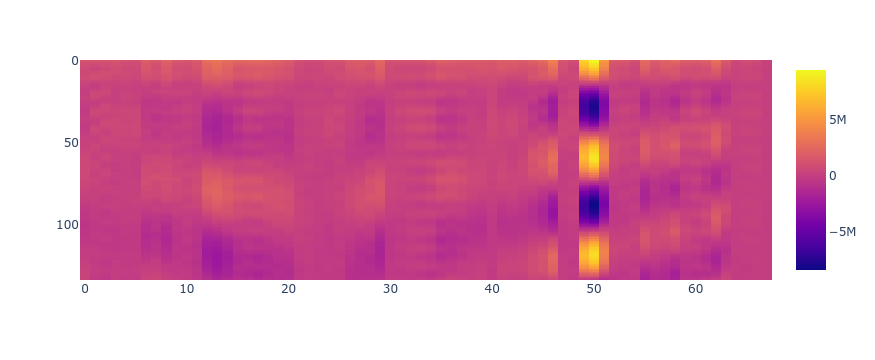

In [198]:
px.imshow(x.T, aspect='auto')